## Load data

In [32]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display

plt.style.use('seaborn-v0_8-paper')

In [33]:
def load_data(phase, path = os.getcwd()):
    if phase == "dev":
        data_path = os.path.join("dsl_data", "development.csv")
    elif phase == "eval":
        data_path = os.path.join("dsl_data", "evaluation.csv")
    else:
        raise Exception(f"Error - phase '{phase}' not recognised.")

    df = pd.read_csv(os.path.join(path, data_path))

    rates = []
    datas = []
    for wav_path in df["path"]:
        audio, sample_rate = librosa.load(os.path.join(path, wav_path), sr=None)
        rates.append(sample_rate)
        datas.append(audio)
    df["rate"] = rates
    df["data"] = datas

    if phase == "dev":
        df["intent"] = df["action"] + df["object"]
        df.drop(columns=["action", "object"], inplace=True)
    
    return df

In [34]:
df_dev  = load_data("dev")
df_eval = load_data("eval")

## Preprocessing

Exclusively for the preprocessing phase, we will concat the development and evaluation data set. In this way we can modify the variables only once and study the distribution of the data in more detail.

In [35]:
df = pd.concat([df_dev, df_eval], sort=False, ignore_index=True)
df_dev.shape, df_eval.shape, df.shape

((9854, 11), (1455, 10), (11309, 11))

check for missing values

In [36]:
pd.DataFrame({"Type": df.dtypes, "NaN": df.isna().any(axis=0), "# unique": df[df.columns.drop("data")].nunique()})

,Type,NaN,# unique
Current language used for work/school,object,False,4.0
First Language spoken,object,False,5.0
Id,int64,False,9854.0
Self-reported fluency level,object,False,4.0
ageRange,object,False,3.0
data,object,False,NaN
gender,object,False,2.0
intent,object,True,7.0
path,object,False,11309.0
rate,int64,False,2.0


Just `intent`, but it is because `df_eval` does not have the label column

Let's do some plots to study the distributions of the variables

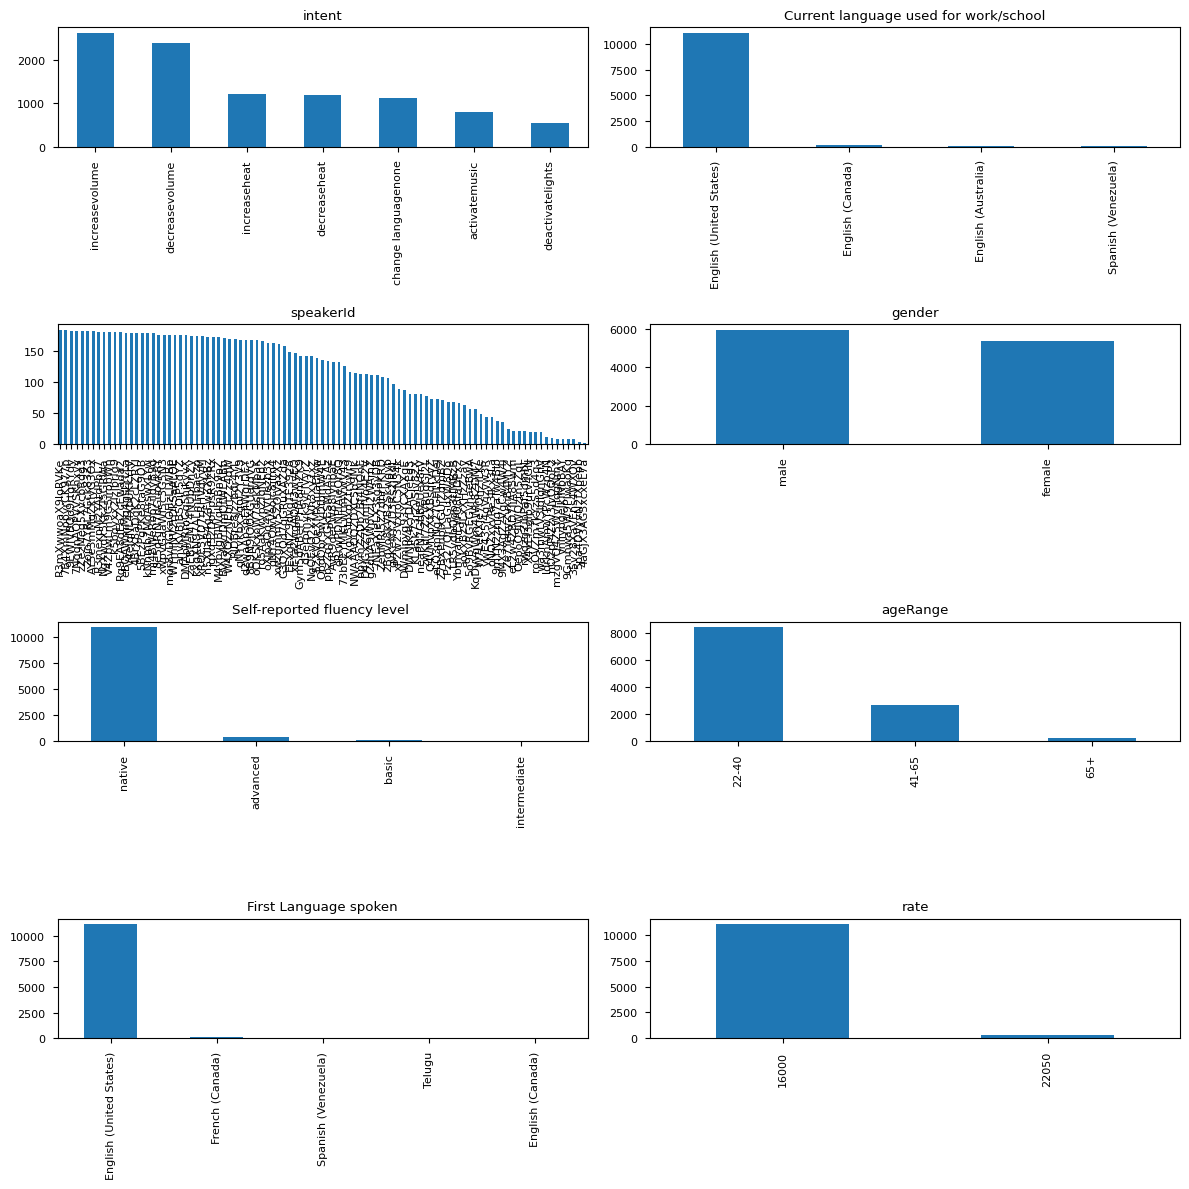

In [37]:
cols = ["intent", "speakerId", "Self-reported fluency level ", "First Language spoken", "Current language used for work/school", "gender", "ageRange", "rate"]
fig, ax = plt.subplots(4, 2, figsize=(12, 12))
for idx, c in enumerate(cols):
    if idx < 4:
        j = 0
    else:
        j = 1
    df[c].value_counts().plot.bar(ax=ax[idx%4][j])
    ax[idx%4][j].set_title(c)
plt.tight_layout()
plt.show()

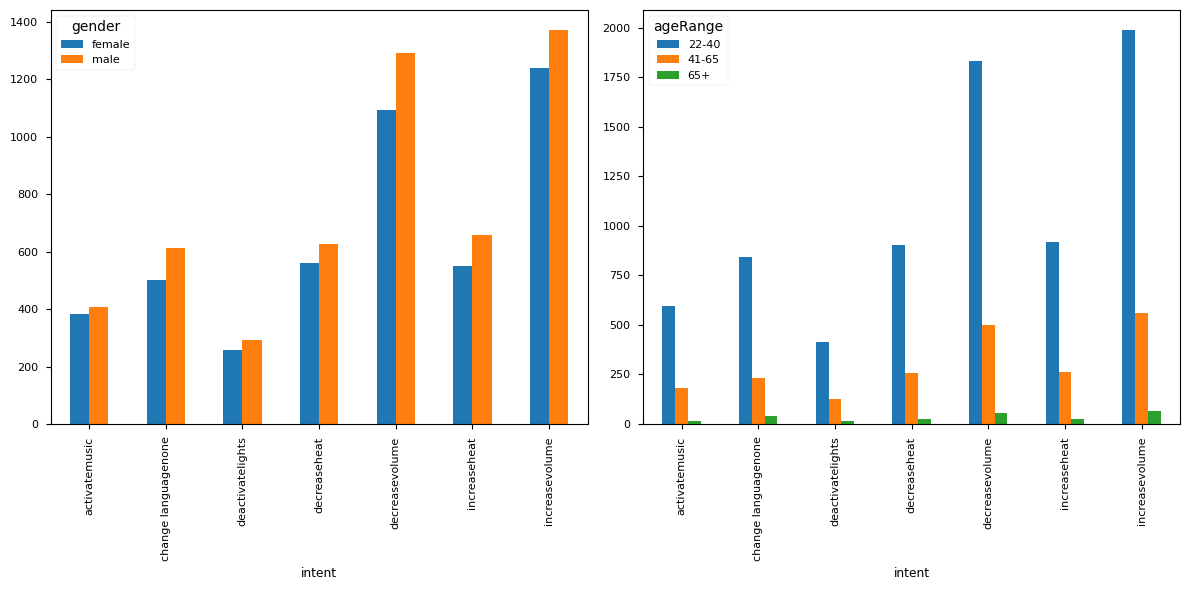

In [38]:
cols = ["gender", "ageRange"]
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
for i, c in enumerate(cols):
    table = pd.pivot_table(df, columns=[c], index=["intent"], values="rate", aggfunc="count")
    table.plot(kind = "bar", ax=ax[i])
plt.tight_layout()
plt.show()

Note that the majority of the speakers are native english (united states). So we could discard the language features     

Moreover, there are two type of sample rates.   
The distribution of the length of data is the following

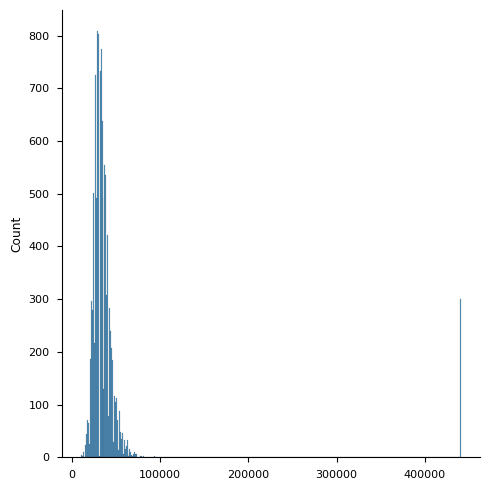

In [39]:
from seaborn import displot
displot([len(data) for data in df["data"]])

There are some same which are very long. Now let s plot the amplitude of the audio to see how they are made

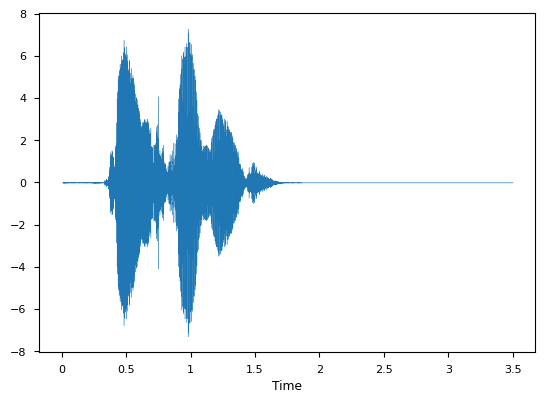

In [31]:
fig, ax = plt.subplots()
librosa.display.waveshow(df["data"][0], sr=df["rate"][0], ax=ax)

<AxesSubplot: xlabel='Time'>

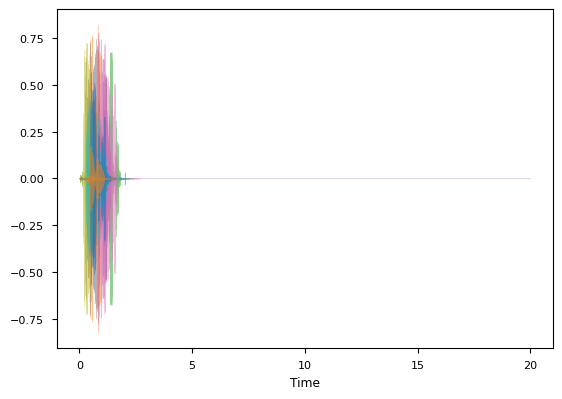

In [40]:
def plot_audio_samples(datas, rates):
    fig, ax = plt.subplots()
    for idx in range(0, len(datas), 1000):
        librosa.display.waveshow(datas[idx], sr=rates[idx], alpha=0.5, ax=ax)
    return ax

plot_audio_samples(df["data"], df["rate"])

first we can see that the signal could be normalized in order to have each amplitude in the same range.
This is done independently for each sample.

In [42]:
df["data"] = [librosa.util.normalize(data) for data in df["data"]]

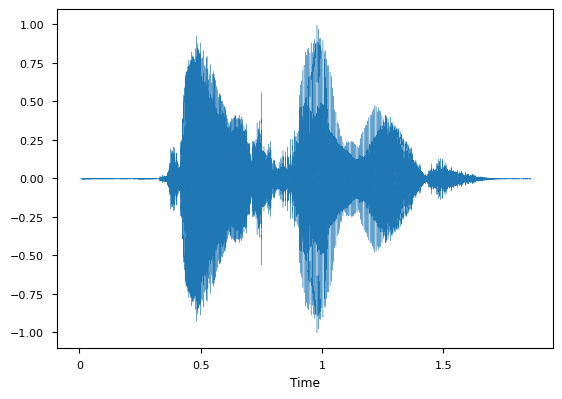

In [43]:
fig, ax = plt.subplots()
librosa.display.waveshow(df["data"][0], sr=df["rate"][0], ax=ax)

<AxesSubplot: xlabel='Time'>

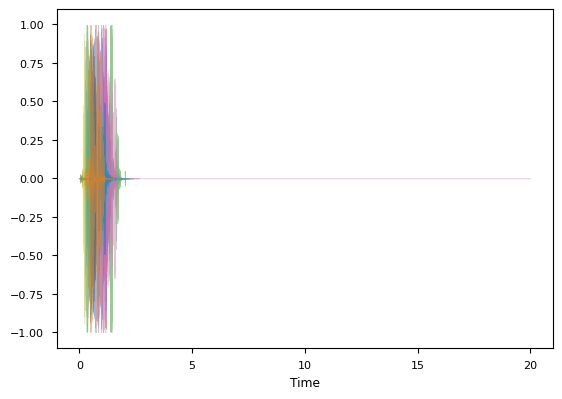

In [44]:
plot_audio_samples(df["data"], df["rate"])

We should pad and cut to have the same length for each audio. Thus, we get the same number of features for each sample

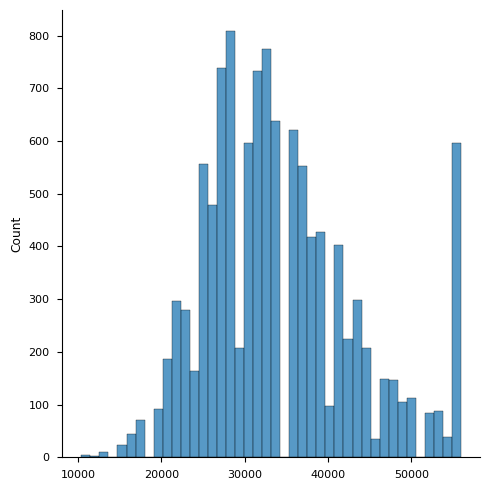

In [45]:
lengths = [len(data) for data in df["data"]]
perc = 95
desired_length = int(np.ceil(np.percentile(lengths, perc)))

df["data"] = [data[:desired_length] for data in df["data"]]
displot([len(data) for data in df["data"]])

Now, we add padding at the end in order to have equal lenght.
We add some  zeros, which represents silence

In [46]:
df["data"] = [np.pad(data, (0,desired_length-len(data)), constant_values=0.0) for data in df["data"]]

Let's extract the Mel-frequency cepstral coefficients (MFCCs) using the `librosa.feature.mfcc()` function.

In [64]:
mfccs = [librosa.feature.mfcc(y=data, sr=rate) for data, rate in zip(df["data"], df["rate"])]
mfccs[0].shape, mfccs[1].shape, mfccs[2].shape

((20, 110), (20, 110), (20, 110))

we get the spectogram using the function `librosa.stft`, which stands for Short-time Fourier transform (STFT).
It represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows.
`n_ftt` is the length of the windowed signal after padding with zeros. The suggested value for speech recognition is 512.

In [19]:
# spects = [librosa.stft(data, n_fft=512) for data in df["data"]]
# spects[0].shape, spects[1].shape, spects[3].shape

Note that, while the first dimension is constant because it refers to the frequency, the second is not. That is because it represents the time.
Therefore, if we would like to sample statistics for boxes of the spectogram, we should add padding to have all the same time length, or change the size of the boxes for each spectogram.

We will use the logarithmic scale on the y axis

In [20]:
# fig, ax = plt.subplots()
# img = librosa.display.specshow(np.abs(spects[0]), x_axis='time', y_axis='log', ax=ax)
# fig.colorbar(img, ax=ax, format="%+2.f dB")

Observe that there are not much infos. Thus it is better to convert the amplitude into decibel. The conversion is logarithmic and reflect the human perception of sounds. Thus, it creates more informative and coherent datas.

In [21]:
# spects_db = [librosa.amplitude_to_db(np.abs(spect), ref=np.max) for spect in spects]
# spects_db[0].shape, spects_db[1].shape, spects_db[3].shape

Same reasonment as before regarding the data shapes.

In [22]:
# fig, ax = plt.subplots()
# img = librosa.display.specshow(spects_db[0], x_axis='time', y_axis='log', ax=ax)
# fig.colorbar(img, ax=ax, format="%+2.0f dB")

Studies have shown that humans do not perceive frequencies on a linear scale. The mel scale have been build to represents how we perceive frequencies. A mel spectrogram is a spectrogram where the frequencies are converted to the mel scale.

In [47]:
mel_spects = [librosa.feature.melspectrogram(y=data, n_fft=512) for data in df["data"]]
mel_spects_db = [librosa.power_to_db(mel_spect, ref=np.max) for mel_spect in mel_spects]
mel_spects_db[0].shape, mel_spects_db[1].shape, mel_spects_db[3].shape

((128, 110), (128, 110), (128, 110))

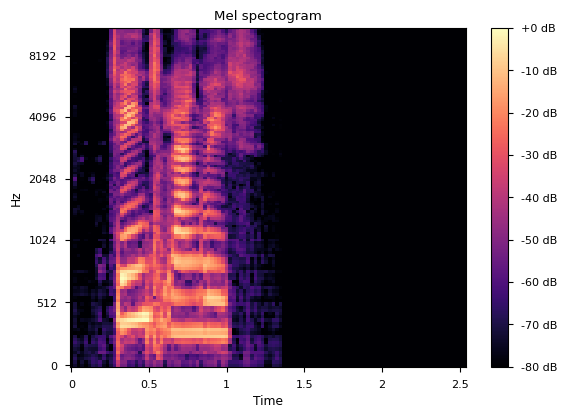

In [48]:
fig, ax = plt.subplots()
img = librosa.display.specshow(mel_spects_db[0], x_axis='time', y_axis='mel', ax=ax)
ax.set(title="Mel spectogram")
fig.colorbar(img, ax=ax, format="%+2.0f dB")

FUNCTIONS FOR DWT PREPROCESSING OF DATA

Let's perform the Discrete Wavelet Transformation(DWT) in order to improve the algorithm performance on recordings with noise.
We'll use the PyWavelet package function 'wavedec' on mel-scaled and log-scaled data to perform the task.

In [51]:
import pywt

# Perform the DWT on the mel-spectrogram
coeffs = [pywt.wavedec(mel_spects_db_elem, 'db4', level=2) for mel_spects_db_elem in mel_spects_db]

# Flatten the DWT coefficients
coeffs = [[coeff.flatten() for coeff in coeffs[i]] for i in range(11309)]

There are three layers for each object, for each layer we compute statistical features and then we will join the 3 groups of features together

In [ ]:
eval_mask = df["intent"].isna()
x_dev = mel_spects_db[~eval_mask]
y = df["intent"][~eval_mask]
x_eval = mel_spects_db[eval_mask]

In [ ]:
#x_eval = [[compute_statistical_features(x.reshape(-1,1), n=32, m=1) for x in x_eval[i]] for i in range(len(x_eval))]
x_eval = [np.hstack(x) for x in x_eval]

#x_dev = [[compute_statistical_features(x.reshape(-1,1), n=32, m=1) for x in x_dev[i]] for i in range(len(x_dev))]
x_dev = [np.hstack(x) for x in x_dev]

test split used for the dwt transformed data

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_dev, y, test_size=0.20)
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
y_train.shape

## Classify

We decide to drop all the decision variables regarding language because not significant

Since the shapes are all big matrices, we could get some statistical measures from each $n \times m$ box. In particular we have chosen
- mean
- standard deviation
- minimum
- maximum

In [50]:
def compute_statistical_features(matrix, n = 4, m = 10):
    feat = []
    N, M = matrix.shape
    for i in range(0, N, n):
        for j in range(0, M, m):
            feat.append(np.array([
                np.mean(matrix[i:i+n, j:j+m]),
                np.std(matrix[i:i+n, j:j+m]),
                np.min(matrix[i:i+n, j:j+m]),
                np.max(matrix[i:i+n, j:j+m])
                ]))
    return np.hstack(feat)

### Convolutional Neural Network

Get the values data set and target values (one hot encoded) which are needed for the cnn.
Note that the cnn discard all the categorical variables. It studies just the image of the mel spectogram to decibel.

In [57]:
from sklearn.model_selection import train_test_split

eval_mask = df["intent"].isna()
mel_spects_db = np.array(mel_spects_db)
x_dev = mel_spects_db[~eval_mask]
y = pd.get_dummies(df["intent"][~eval_mask])
x_eval = mel_spects_db[eval_mask]

x_train, x_test, y_train, y_test = train_test_split(x_dev, y, test_size=0.2)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((7883, 128, 110), (1971, 128, 110), (7883, 7), (1971, 7))

In [60]:
import tensorflow as tf

# define the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 110, 1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(7, activation='softmax')) # modify the output layer to have 7 units and softmax activation

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
247/247 [==============================] - 131s 524ms/step - loss: 4.3376 - accuracy: 0.2991 - val_loss: 1.4944 - val_accuracy: 0.3973
Epoch 2/5
247/247 [==============================] - 107s 433ms/step - loss: 1.3435 - accuracy: 0.4647 - val_loss: 1.3142 - val_accuracy: 0.4886
Epoch 3/5
247/247 [==============================] - 104s 422ms/step - loss: 1.0647 - accuracy: 0.5728 - val_loss: 1.2159 - val_accuracy: 0.5393
Epoch 4/5
247/247 [==============================] - 112s 454ms/step - loss: 0.8101 - accuracy: 0.6811 - val_loss: 1.2167 - val_accuracy: 0.5495
Epoch 5/5
247/247 [==============================] - 123s 499ms/step - loss: 0.5749 - accuracy: 0.7738 - val_loss: 1.3059 - val_accuracy: 0.5718


### Test different models

In [65]:
# matrices of which we want to compute the statistical features
features = np.vstack([compute_statistical_features(x, n=2, m=11) for x in mfccs])

encode the categorical variables of our data set using one hot encoding

In [66]:
cols_to_keep = ["speakerId", "gender", "ageRange"]
cols_to_encode = ["speakerId", "gender", "ageRange"]
df_1h = pd.get_dummies(df[cols_to_keep], columns=cols_to_encode)
X = np.hstack([df_1h.values, features])
X.shape

(11309, 502)

Define the data set `X_dev` and `X_eval` which will be used for training and test. Then define `y` which are the training labels

In [67]:
eval_mask = df["intent"].isna()
X_dev = X[~eval_mask]
X_eval = X[eval_mask]
y = df["intent"][~eval_mask]
X_dev.shape, y.shape, X_eval.shape

((9854, 502), (9854,), (1455, 502))

Lets see the effect of the PCA on the new features

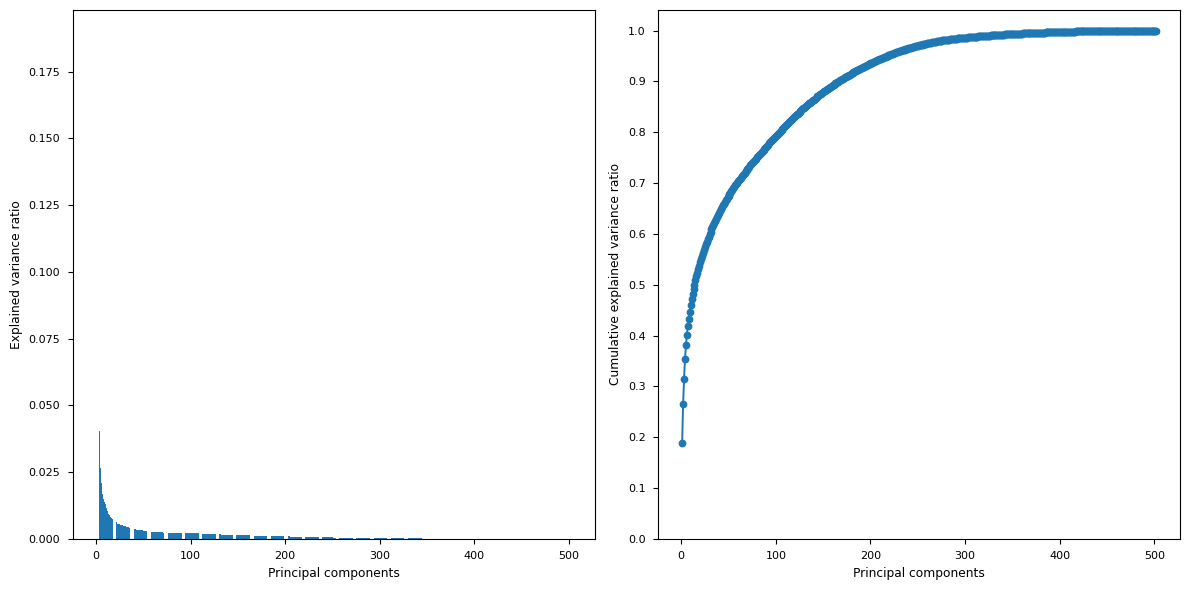

In [69]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pre = make_pipeline(
    StandardScaler(),
    PCA()
)
pca_df_scaled = pre.fit_transform(X_dev)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].bar(range(1,len(pre["pca"].explained_variance_ratio_)+1), pre["pca"].explained_variance_ratio_)
ax[0].set_xlabel("Principal components")
ax[0].set_ylabel("Explained variance ratio")
ax[1].plot(range(1,len(pre["pca"].explained_variance_ratio_)+1), pre["pca"].explained_variance_ratio_.cumsum(), marker="o")
ax[1].set_xlabel("Principal components")
ax[1].set_ylabel("Cumulative explained variance ratio")
ax[1].set_yticks(np.arange(0, 1.1, 0.1))
plt.tight_layout()
plt.show()

In [70]:
qs = [0.85, 0.90, 0.95]
zs = []
for q in qs:
    z = next(x[0] for x in enumerate(pre["pca"].explained_variance_ratio_.cumsum()) if x[1] > q)
    print(f"The {q}% of the data has length lower or equal to {z}.")
    zs.append(z)

The 0.85% of the data has length lower or equal to 130.
The 0.9% of the data has length lower or equal to 166.
The 0.95% of the data has length lower or equal to 217.


function to test the various model and than the `param_grids` and `models` variables in order to make life easier.

In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def test_model(model, params, X, y, cv=5, scale=False, pca=False, n_components=100):
    # Scale the data if necessary
    if scale:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    # Perform PCA if necessary
    if pca:
        pca = PCA(n_components=100)
        X = pca.fit_transform(X)
    # Create a grid search object
    gs = GridSearchCV(model, params, cv=cv, scoring="accuracy")
    # Fit the model
    gs.fit(X, y)
    # Get the best model and score
    best_model = gs.best_estimator_
    best_score = gs.best_score_
    # Return the best model and score
    return best_model, best_score

    
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

param_grids = {
    "rf": {
        "n_estimators": [200]
    },
    "svc": {
        'kernel': ['linear', 'rbf'],
        'C': [0.1, 1.0, 10.0]
    }
}
models = {
    "rf": RandomForestClassifier(),
    "svc": SVC()
}

Support Vector Machine (base and ensemble methods)

In [73]:
from sklearn. svm import SVC

svm_params = {
    "kernel": ['linear'],
    "C": [10, 1, 0.1]
}

best_model, best_score = test_model(SVC(), svm_params, X_dev, y, scale=True, pca=True, n_components=zs[2])
print(f"""
    {best_model = }
    {best_score = }
""")


SVM ensemble method

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC

# Create the base SVM model
svm = SVC(C=0.45)

ensemble_params = {
    "base_estimator": [svm],
    "n_estimators": [10],
    "bootstrap": [True, False]
}

best_model, best_score = test_model(BaggingClassifier(), ensemble_params, X_dev, y, scale=True, pca=False, n_components=zs[1])
print(f"""
    {best_model = }
    {best_score = }
""")


    best_model = BaggingClassifier(base_estimator=SVC(C=0.45))
    best_score = 0.41272342365312253



Tree Classifier

Firstly we'll try to apply the DecisionTreeClassifier method with default parameters in order to check which depth is reached by the tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_dev, y)
clf.tree_.max_depth


28

In [ ]:
tree_params = {
    "max_depth": [20],
    "min_impurity_decrease": [0],
    "min_samples_leaf" : [7, 8 , 9],
    "max_leaf_nodes" : [ 200]
}

best_model, best_score = test_model(DecisionTreeClassifier(), tree_params, X_dev, y, scale=True, pca=False, n_components=zs[1])
print(f"""
    {best_model = }
    {best_score = }
""")


    best_model = DecisionTreeClassifier(max_depth=20, max_leaf_nodes=200,
                       min_impurity_decrease=0, min_samples_leaf=7)
    best_score = 0.35498077453017995



Random forest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_params = {
    "max_depth": [20, 25, 15],
    "n_estimators": [200, 400],
    "max_features": [None, 'sqrt'],
    "n_jobs" : [-1],
    "random_state":[1],
    "oob_score" : [False]
}

best_model, best_score = test_model(RandomForestClassifier(), forest_params, X_dev, y, scale=True, pca=False, n_components=zs[1])
print(f"""
    {best_model = }
    {best_score = }
""")

C:\Users\giuli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



    best_model = RandomForestClassifier(max_depth=25, max_features=None, n_estimators=400,
                       n_jobs=-1, random_state=1)
    best_score = 0.4846718020433339



Function to try multiple models and hyperparameters

In [ ]:
for key, model in models.items():
    best_model, best_score = test_model(model, param_grids[key], X_dev, y, scale=True, pca=True, n_components=zs[1])
    print(f"""
        {best_model = }
        {best_score = }
    """)


        best_model = RandomForestClassifier(n_estimators=200)
        best_score = 0.30911119867520676
    

        best_model = SVC()
        best_score = 0.3294090196169328
    


Recurrent Neural Network (not used and fully implemented yet, and I don't want to use it for now)

In [ ]:

import tensorflow as tf
from sklearn.model_selection import GridSearchCV

# Define a function to create the model
def create_model(num_units, activation):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(num_units, input_shape=X_dev.shape[1:]))
  model.add(tf.keras.layers.Dense(7, activation=activation))
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

# Create the model
model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=10, batch_size=32)

# Define the hyperparameter search space
param_grid = {'num_units': [32],
              'activation': ['relu']}

# Create the grid search object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# Fit the grid search object to the training data
grid_search.fit(X_dev, y)

# Print the best set of hyperparameters
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

ModuleNotFoundError: No module named 'tensorflow.python'

To create the csv file that must be uploaded

In [ ]:
# y_pred = best_model.predict(X_eval)
# pd.DataFrame(y_pred, index=df["Id"][mask]).to_csv("output.csv", index_label="Id", header=["Predicted"])

In [63]:
# predict the class with the maximum probability
predictions = model.predict(x_eval)
max_prediction = y.columns[predictions.argmax(axis=1)]
pd.DataFrame(max_prediction, index=df["Id"][eval_mask]).to_csv("output.csv", index_label="Id", header=["Predicted"])

46/46 [==============================] - 5s 116ms/step
